<a href="https://colab.research.google.com/github/sandeep1847e/Phy654-data/blob/main/WaveSolUsingNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Wave equation solution**

The problem to solve for
The wave equation to solve for, is

∂2g(x,t)∂t2=c2∂2g(x,t)∂x2
where c
 is the given wave speed. The chosen conditions for this equation are

g(0,t)g(1,t)g(x,0)∂g(x,t)∂t∣∣∣t=0=0,=0,=u(x),=v(x),t≥0t≥0x∈[0,1]x∈[0,1]
In this example, let c=1
 and u(x)=sin(πx)
 and v(x)=−πsin(πx)
.

The trial solution
Setting up the network is done in similar matter as for the example of solving the diffusion equation. The only things we have to change, is the trial solution such that it satisfies the conditions from (???)
 and the cost function.

The trial solution becomes slightly different since we have other conditions than in the example of solving the diffusion equation. Here, a possible trial solution gt(x,t)
 is

gt(x,t)=h1(x,t)+x(1−x)t2N(x,t,P)

where

h1(x,t)=(1−t2)u(x)+tv(x)

Note that this trial solution satisfies the conditions only if u(0)=v(0)=u(1)=v(1)=0
, which is the case in this example.

The analytical solution
The analytical solution for our specific problem, is

g(x,t)=sin(πx)cos(πt)−sin(πx)sin(πt)



Initial cost: 83.52120709445744
Iteration 0, Cost: 82.76493487644724
Iteration 10, Cost: 76.1798269061885
Iteration 20, Cost: 71.04847052049773
Iteration 30, Cost: 67.01287368529174
Iteration 40, Cost: 63.815320701341044
Iteration 50, Cost: 61.266902533010864
Iteration 60, Cost: 59.22644289310792
Iteration 70, Cost: 57.58665392406823
Iteration 80, Cost: 56.26474606534826
Iteration 90, Cost: 55.19616909406449
Iteration 100, Cost: 54.33008258502963
Iteration 110, Cost: 53.62620436452781
Iteration 120, Cost: 53.052452930209164
Iteration 130, Cost: 52.583135866548766
Iteration 140, Cost: 52.19768874067824
Iteration 150, Cost: 51.87953652171846
Iteration 160, Cost: 51.61532432651078
Iteration 170, Cost: 51.394319619451
Iteration 180, Cost: 51.207838514088664
Iteration 190, Cost: 51.04884500051179
Iteration 200, Cost: 50.91167067725095
Iteration 210, Cost: 50.791724663915026
Iteration 220, Cost: 50.6852806475832
Iteration 230, Cost: 50.58931504160494
Iteration 240, Cost: 50.50138896391182
It

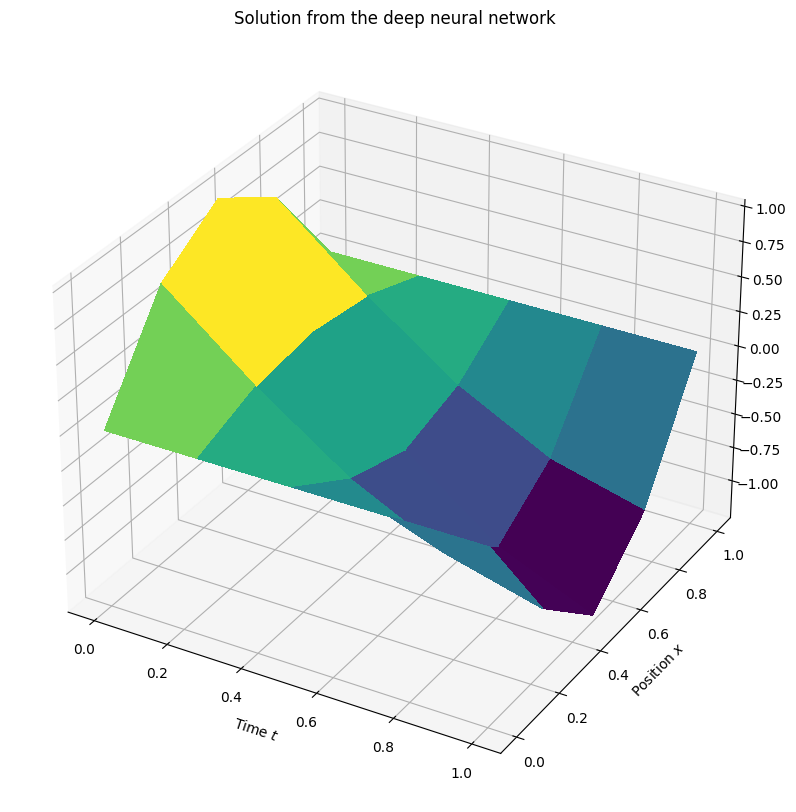

In [29]:

import autograd.numpy as np
from autograd import grad
import autograd.numpy.random as npr
from matplotlib import cm
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import axes3d

# Set up the trial function:
def u(x):
    return np.sin(np.pi * x)

def v(x):
    return -np.pi * np.sin(np.pi * x)

def h1(point):
    x, t = point
    return (1 - t ** 2) * u(x) + t * v(x)

def g_trial(point, P):
    x, t = point
    return h1(point) + x * (1 - x) * t ** 2 * deep_neural_network(P, point)

# Define finite difference approximation for second derivatives
def finite_diff_second_deriv(func, point, P, idx, h=1e-5):
    point_fwd = np.copy(point)
    point_bwd = np.copy(point)

    point_fwd[idx] += h
    point_bwd[idx] -= h

    return (func(point_fwd, P) - 2 * func(point, P) + func(point_bwd, P)) / h**2

# Define the cost function using finite differences
def cost_function(P, x, t):
    cost_sum = 0

    for x_ in x:
        for t_ in t:
            point = np.array([x_, t_])

            # Finite difference approximation for second derivatives
            g_t_d2x = finite_diff_second_deriv(g_trial, point, P, 0)  # Second derivative w.r.t. x
            g_t_d2t = finite_diff_second_deriv(g_trial, point, P, 1)  # Second derivative w.r.t. t

            # Wave equation: d^2g/dt^2 - d^2g/dx^2 = 0
            err_sqr = (g_t_d2t - g_t_d2x) ** 2
            cost_sum += err_sqr

    return cost_sum / (np.size(t) * np.size(x))

# The neural network
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def deep_neural_network(deep_params, x):
    # x is now a point (1D numpy array); make it a column vector
    num_coordinates = np.size(x, 0)
    x = x.reshape(num_coordinates, -1)
    num_points = np.size(x, 1)

    N_hidden = len(deep_params) - 1  # Number of hidden layers

    x_prev = x

    # Hidden layers:
    for l in range(N_hidden):
        w_hidden = deep_params[l]
        x_prev = np.concatenate((np.ones((1, num_points)), x_prev), axis=0)  # Add bias
        z_hidden = np.matmul(w_hidden, x_prev)
        x_prev = sigmoid(z_hidden)

    # Output layer:
    w_output = deep_params[-1]
    x_prev = np.concatenate((np.ones((1, num_points)), x_prev), axis=0)  # Add bias
    z_output = np.matmul(w_output, x_prev)
    x_output = z_output

    return x_output[0, 0]

# Analytical solution for the wave equation
def g_analytic(point):
    x, t = point
    return np.sin(np.pi * x) * np.cos(np.pi * t) - np.sin(np.pi * x) * np.sin(np.pi * t)

def solve_pde_deep_neural_network(x, t, num_neurons, num_iter, lmb):
    N_hidden = len(num_neurons)
    P = [None] * (N_hidden + 1)

    # Initialize weights and biases
    P[0] = npr.randn(num_neurons[0], 2 + 1)  # 2 input points + bias
    for l in range(1, N_hidden):
        P[l] = npr.randn(num_neurons[l], num_neurons[l - 1] + 1)  # Include bias

    P[-1] = npr.randn(1, num_neurons[-1] + 1)  # Output layer includes bias

    print('Initial cost:', cost_function(P, x, t))
    cost_function_grad = grad(cost_function, 0)

    for i in range(num_iter):
        cost_grad = cost_function_grad(P, x, t)

        for l in range(N_hidden + 1):
            P[l] = P[l] - lmb * cost_grad[l]  # Gradient descent step

        if i % 10 == 0:
            print(f"Iteration {i}, Cost: {cost_function(P, x, t)}")

    print('Final cost:', cost_function(P, x, t))

    return P

if __name__ == '__main__':
    npr.seed(15)

    # Set up input values
    Nx = 5  # Reduced for faster computation
    Nt = 5  # Reduced for faster computation
    x = np.linspace(0, 1, Nx)
    t = np.linspace(0, 1, Nt)

    # Neural network setup
    num_hidden_neurons = [10, 5]  # Reduced neurons
    num_iter = 1000  # Reduced iterations for quicker test
    lmb = 0.001  # Smaller learning rate

    P = solve_pde_deep_neural_network(x, t, num_hidden_neurons, num_iter, lmb)

    # Store results
    res = np.zeros((Nx, Nt))
    res_analytical = np.zeros((Nx, Nt))
    for i, x_ in enumerate(x):
        for j, t_ in enumerate(t):
            point = np.array([x_, t_])
            res[i, j] = g_trial(point, P)
            res_analytical[i, j] = g_analytic(point)

    diff = np.abs(res - res_analytical)
    print("Max difference between analytical and solution from nn: %g" % np.max(diff))

    # Plot solutions
    T, X = np.meshgrid(t, x)

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')  # Corrected this line
    ax.set_title('Solution from the deep neural network')
    ax.plot_surface(T, X, res, linewidth=0, antialiased=False, cmap=cm.viridis)
    ax.set_xlabel('Time $t$')
    ax.set_ylabel('Position $x$')



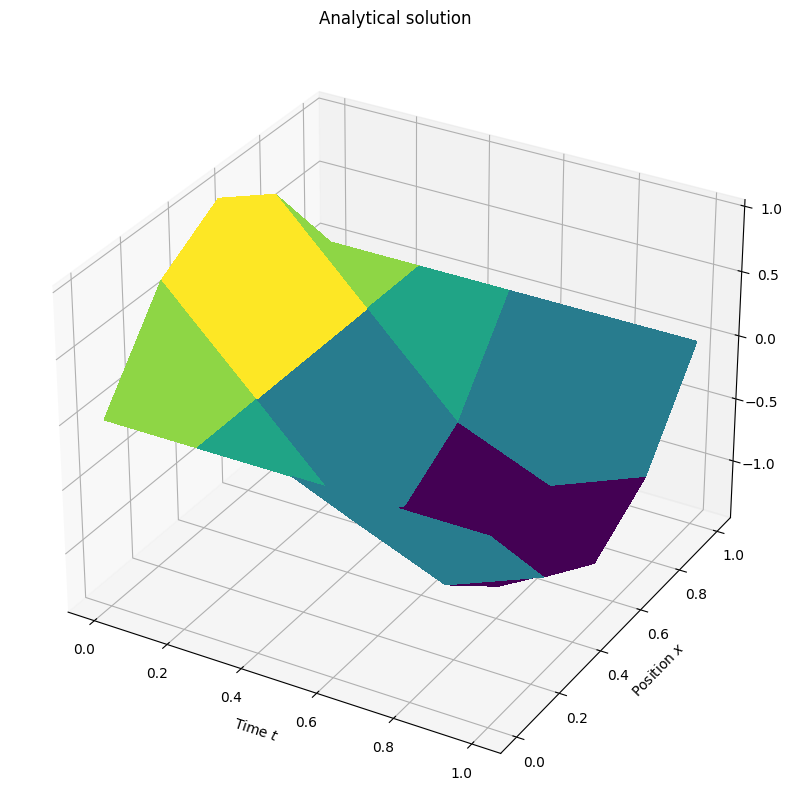

In [31]:

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')  # Corrected this line
    ax.set_title('Analytical solution')
    ax.plot_surface(T, X, res_analytical, linewidth=0, antialiased=False, cmap=cm.viridis)
    ax.set_xlabel('Time $t$')
    ax.set_ylabel('Position $x$')
    plt.show()

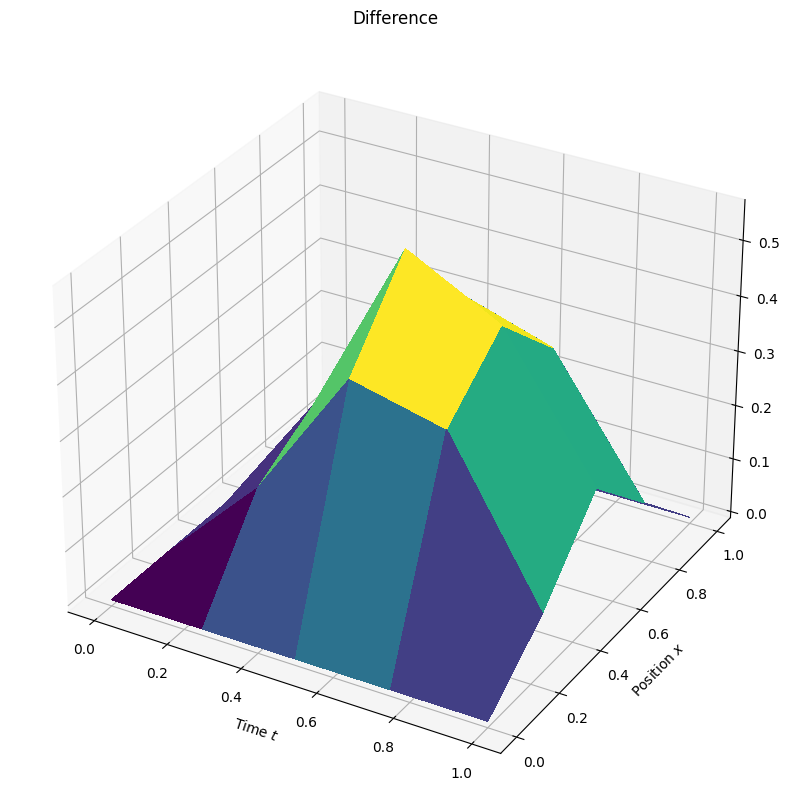

In [30]:

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')  # Corrected this line
    ax.set_title('Difference')
    ax.plot_surface(T, X, diff, linewidth=0, antialiased=False, cmap=cm.viridis)
    ax.set_xlabel('Time $t$')
    ax.set_ylabel('Position $x$')
    plt.show()